<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/01_Computer_Vision_regex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

NOTE:  the lines above make sure that any updates to the underlying library at any point of time should be automatically reloaded/refreshed.

In [ ]:
#Run once per session in a quiet mode -- less output
!pip install fastai2 -q

     |████████████████████████████████| 194kB 2.6MB/s 


In [ ]:
# package to get prettier results in the notebook
!pip install nbdev -q

     |████████████████████████████████| 51kB 1.6MB/s 


In [ ]:
# checking the fastai2 version (optional)
import fastai2; fastai2.__version__

'0.0.17'

In [ ]:
# importing fastai2 vision
from fastai2.vision.all import *

# Getting the data

In [ ]:
# getting the dataset
path_img = untar_data(URLs.PETS,dest='/content/Pets')/'images'

NOTE:  ‘/‘ (slash) operator is python 3 operator which is part of the pathlib library.

In [ ]:
path_img

Path('/content/Pets/oxford-iiit-pet/images')

NOTE: The Pet dataset contains **7,390 pictures of dogs and cats, consisting of 37 different breeds**. Each image is labeled using its filename: for instance the file great_pyrenees_173.jpg is the 173rd example of an image of a Great Pyrenees breed dog in the dataset.

- fastai datasets https://course.fast.ai/datasets
- URLs is a class from fastai. 
- PETS is a string constant with the path as ‘https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet

In [ ]:
# displaying the path for 3 images
path_img.ls()[:3]

(#3) [Path('/content/Pets/oxford-iiit-pet/images/Sphynx_211.jpg'),Path('/content/Pets/oxford-iiit-pet/images/Birman_148.jpg'),Path('/content/Pets/oxford-iiit-pet/images/american_bulldog_167.jpg')]

In [ ]:
path_img.absolute()

Path('/content/Pets/oxford-iiit-pet/images')

## Getting documentation

In [ ]:
# help(function-name)
help(untar_data)

Help on function untar_data in module fastai2.data.external:

untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=<function file_extract at 0x7f131371cd08>)
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz or unzip to folder `dest`.



In [ ]:
# ?function-name: Shows the definition and docstring for that function
?untar_data

In [ ]:
# ??function-name: Shows the source code for that function
??untar_data

In [ ]:
# doc(function-name): Shows the definition, docstring and links to the documentation of the function (only works with fastai library imported)
doc(untar_data)

In [ ]:
# getting a few image files
fnames = get_image_files(path_img)
fnames[:5]

(#5) [Path('/content/Pets/oxford-iiit-pet/images/Sphynx_211.jpg'),Path('/content/Pets/oxford-iiit-pet/images/Birman_148.jpg'),Path('/content/Pets/oxford-iiit-pet/images/american_bulldog_167.jpg'),Path('/content/Pets/oxford-iiit-pet/images/american_pit_bull_terrier_46.jpg'),Path('/content/Pets/oxford-iiit-pet/images/scottish_terrier_28.jpg')]

# Regular Expression
A regular expression (or RE) specifies a set of strings that matches it; if a particular string matches a given regular expression.

In [ ]:
pat = r'/([^/]+)_\d+.jpg$'

NOTE: regex expression
- $	end of search
- .jpg	last chars to be found in the search string, also right file format checking
- \d	numerical digits, ‘+’ sign denotes can be one or more of them
- _	should come before the start of digits
- ()	denotes a group of characters
- []	denotes another subgroup if characters in the previous group
- ^/	‘^’ denotes negation, so ‘+’ says all other chars except ‘/’
- ( [ ^/ ] + )	searches all characters except ‘/’
- /	first ‘/’ in regex says, end of search
- r	The string should be a raw string. - 

Otherwise, \d would have to be written as \\d so that Python doesn’t interpret it to be a special character.

[Regex Tutorial](https://regexone.com/)


#DataLoader
To get our data ready for a model, we need to put it in a DataLoaders object. Here we are going to use a regex expression to extract labels from the file names, so we will use ImageDataLoaders, `from_path_re`. There are other factory methods of ImageDataLoaders that could be more suitable for your problem, so make sure to check them all in vision.data.

## Using Regex

In [ ]:
# dataloader using a regular expression
# -- training set = 80% of the dataset
# -- validation set = 20% of the dataset
data = ImageDataLoaders.from_path_re(path_img, fnames, pat, item_tfms=Resize(224))

NOTE: `item_tfms`: this is a Transform applied on all items of our dataset that will resize each image to 224 by 224 px, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn't pass this, we would get an error later as it would be impossible to batch the items together.

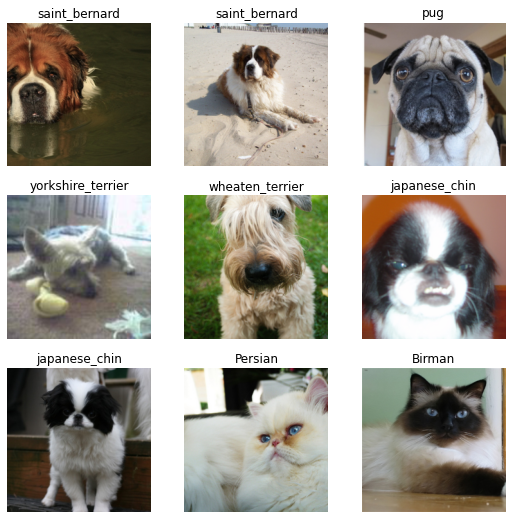

In [ ]:
# selecting data from the train dataset
data.train.show_batch()

NOTE:  Regular expression applied to get the label for each image.

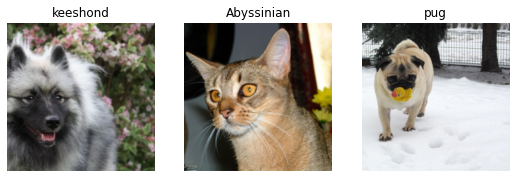

In [ ]:
# selecting data from the train and validation datasets.
data.show_batch(max_n=3)

## Using a function

In [ ]:
# function to find  out if the image is a cat or not
# -- to be used with the dataloader
def is_cat(x): return x[0].isupper()


NOTE: function, `is_cat`, labels cats based on a filename rule provided by the dataset creators. The function will return `True` or `False` depending if the image (`x`) is a cat or a dog.
Cat = `True`, Dog = `False`.

In [ ]:
# dataloader using a function
# -- training set = 80% of the dataset
# -- validation set = 20% of the dataset
dls = ImageDataLoaders.from_name_func(
    path_img, get_image_files(path_img), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

NOTE: `ImageDataLoaders` using a function. What is needed is:
- the image path
- the files
- the split between the training set and the validation set; in this case we have 80% of the images that will go into the training set, and 20% of the images that will go in the validation set.
- the `seed` for randomization. It makes the random numbers predictable.  If the random seed is not reset, different numbers appear with every invocation.
- the labels, in this case our function `is_cat`
- image resize to 224x224 px

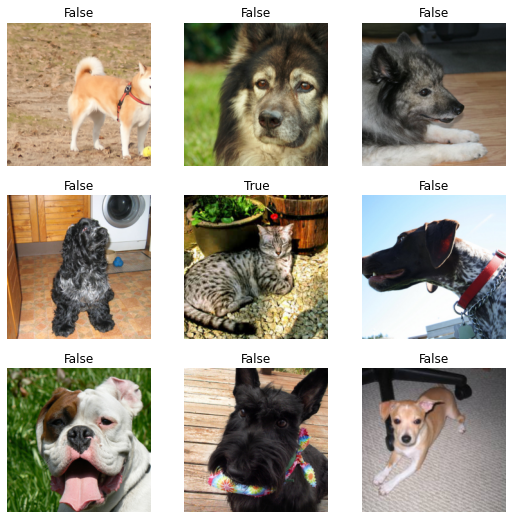

In [ ]:
# displaying pictures in the training set
dls.train.show_batch()

In [ ]:
doc(ImageDataLoaders)

NOTE: function `is_cat` applied, returning `True` if a picture is a cat.

#Training the model
Now, we can create a Learner, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [ ]:
# The learner
# -- the learner contains at minima: the dataloader, the model, a metric
learn = cnn_learner(data, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.503069,0.299560,0.104195,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.443110,0.226971,0.081867,01:10


NOTE1: The first line downloaded a model called ResNet34, pretrained on ImageNet, and adapted it to our specific problem. It then fine tuned that model and in a relatively short time, we get a model with a very low error rate ... amazing!

NOTE:  `fine_tune()` Fine-tuning: A transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a different task to that used for pretraining.

- Use one epoch(an epoch is one complete pass through the input data) to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.
- Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).
- The head of a model is the part that is newly added to be specific to the new dataset. An epoch is one complete pass through the dataset. After calling fit, the results after each epoch are printed, showing the epoch number, the training and validation set losses (the "measure of performance" used for training the model), and any metrics you've requested (error rate, in this case).

In [ ]:
??learn.fine_tune

NOTE1: So, how do we know if this model is any good? In the table above,  you can see the **error rate**, which is the proportion of images that were incorrectly identified. The error rate serves as our metric—our measure of model quality, chosen to be intuitive and comprehensible. As you can see, the model is nearly perfect, even though the training time was only a few seconds (not including the one-time downloading of the dataset and the pretrained model). In fact, the accuracy you've achieved already is far better than anybody had ever achieved just 10 years ago!

NOTE2:  We are using a pre-trained model on [ImageNet](http://www.image-net.org/), so the normalization that was used to pre-train ImageNet is applied to the new dataset (pets).

ImageNet is an image database organised according to the WordNet hierarchy with 14,197,122 images belonging to 21841 classes.

In [ ]:
??cnn_learner

In [ ]:
# model architecture
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Saving the model

In [ ]:
# saving the model
learn.save('/content/Pets/models/stage-1')

NOTE: This will save the model as `.pth` format, which is Pytorch’s default serialization method.
Models will get saved into your local dir in /models folder
Since different model’s weights should be saved separately we use local directories instead of a global one.

# Interpreting the results

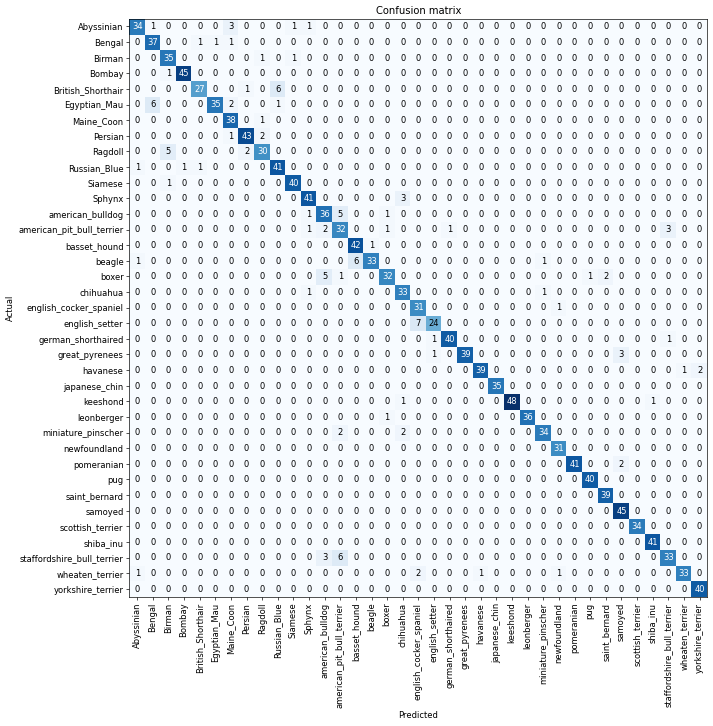

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('english_setter', 'english_cocker_spaniel', 7),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('Egyptian_Mau', 'Bengal', 6),
 ('beagle', 'basset_hound', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Ragdoll', 'Birman', 5),
 ('american_bulldog', 'american_pit_bull_terrier', 5),
 ('boxer', 'american_bulldog', 5),
 ('Abyssinian', 'Maine_Coon', 3),
 ('Sphynx', 'chihuahua', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('great_pyrenees', 'samoyed', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Egyptian_Mau', 'Maine_Coon', 2),
 ('Persian', 'Ragdoll', 2),
 ('Ragdoll', 'Persian', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('boxer', 'saint_bernard', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('pomeranian', 'samoyed', 2),
 ('wheaten_terrier', 'english_cocker_spaniel', 2)]

NOTE: Actual v.s. predicted, number of losses.

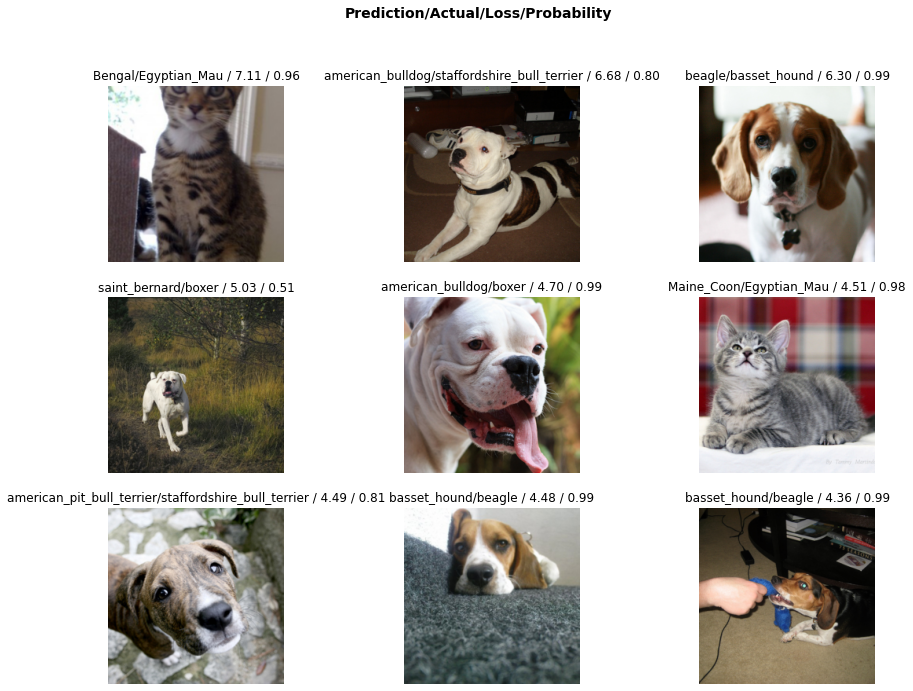

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

NOTE:  We will learn about loss functions shortly. But the idea is **loss function tells you how good was your prediction compared to the ground truth.**
Specifically, that means if you predicted one class of cat with great confidence.

For example, if you confidently predicted this is a Berman cat, but it was wrong; it was a Ragdoll cat. Then it is going to have a very high loss because you were very confident about the wrong answer.
So by plotting the top losses, we are going to plot images that were most confident about the prediction but were wrong.

In [ ]:
doc(interp.plot_top_losses)

# Inference
Finally, let's check that this model actually works. Go and get a photo of a dog, or a cat; if you don't have one handy, just search Google Images and download an image that you find there. 

## Exporting the model

In [ ]:
model_path = Path('/content/Pets/models'); model_path
learn.export('/content/Pets/models/pets.pkl')
model_path.ls(file_exts='.pkl')

(#1) [Path('/content/Pets/models/pets.pkl')]

In [ ]:
learn_inf = load_learner('/content/Pets/models/pets.pkl')

In [ ]:
fn='/content/Pets/inference/dog_lookalike_cat.jpeg'

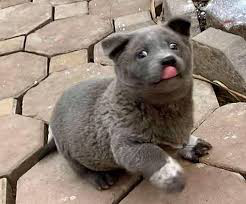

In [ ]:
Image.open(fn)

In [ ]:
learn_inf.predict('/content/Pets/inference/dog_lookalike_cat.jpeg')

('shiba_inu',
 tensor(33),
 tensor([1.0967e-03, 6.9500e-05, 1.5502e-04, 1.0171e-04, 1.4212e-01, 2.2302e-03,
         1.8952e-04, 1.8405e-04, 4.9727e-03, 9.0876e-02, 5.3280e-03, 1.2048e-04,
         1.8047e-03, 1.9371e-01, 1.0108e-04, 5.5160e-04, 1.0974e-04, 3.1838e-04,
         2.4815e-05, 2.8416e-04, 3.8772e-04, 2.0408e-03, 3.2418e-04, 5.0398e-05,
         1.6907e-03, 2.5291e-04, 6.5749e-05, 2.1363e-04, 1.9463e-03, 5.1171e-03,
         8.8561e-04, 1.9865e-03, 5.0448e-04, 2.8894e-01, 2.4155e-01, 8.6094e-03,
         1.0828e-03]))

NOTE:  The predict method returns three things: the decoded prediction (here, the pet breed), the index of the predicted class and the tensor of probabilities that our image is one of a dog (here the model is quite confident!) This method accepts a filename, a PIL image or a tensor directly.

In [ ]:
# getting the classes
learn_inf.dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

## Uploading a file - Python Widget

Now you can pass the uploaded file to the model. Make sure that it is a clear photo of a single dog or a cat, and not a line drawing, cartoon, or similar. The notebook will tell you whether it thinks it is a dog or a cat, and how confident it is. Hopefully, you'll find that your model did a great job:

In [ ]:
import ipywidgets as widgets
img_upl = '/content/Pets/inference/'
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [ ]:
uploader = SimpleNamespace(data = ['/content/Pets/inference/dog_lookalike_cat.jpeg'])

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: shiba_inu.
Probability it's a cat: 0.000069


> jargon: Machine Learning: The training of programs developed by allowing a computer to learn from its experience, rather than through manually coding the individual steps.

# Machine Learning Jargon
Here is the modern deep learning terminology for all the pieces we have discussed:

- The functional form of the *model* is called its *architecture* (but be careful—sometimes people use *model* as a synonym of *architecture*, so this can get confusing).
- The *weights* are called *parameters*.
- The *predictions* are calculated from the *independent variable*, which is the *data* not including the *labels*.
- The *results* of the model are called *predictions*.
- The measure of *performance* is called the *loss*.
- The loss depends not only on the predictions, but also the correct *labels* (also known as *targets* or the *dependent variable*); e.g., "dog" or "cat."


# Limitations Inherent To Machine Learning

From the image classification above the following is important to know

- A model cannot be created without data.
- A model can only learn to operate on the patterns seen in the input data used to train it.
- This learning approach only creates *predictions*, not recommended *actions*.
- It's not enough to just have examples of input data; we need *labels* for that data too (e.g., pictures of dogs and cats aren't enough to train a model; we need a label for each one, saying which ones are dogs, and which are cats).

Generally speaking, we've seen that most organizations that say they don't have enough data, actually mean they don't have enough *labeled* data. If any organization is interested in doing something in practice with a model, then presumably they have some inputs they plan to run their model against. And presumably they've been doing that some other way for a while (e.g., manually, or with some heuristic program), so they have data from those processes! For instance, a radiology practice will almost certainly have an archive of medical scans (since they need to be able to check how their patients are progressing over time), but those scans may not have structured labels containing a list of diagnoses or interventions (since radiologists generally create free-text natural language reports, not structured data). We'll be discussing labeling approaches a lot in this book, because it's such an important issue in practice.



### How Our Image Recognizer Works

Let's see just how our image recognizer code maps to these ideas. We'll put each line into a separate cell, and look at what each one is doing (we won't explain every detail of every parameter yet, but will give a description of the important bits; full details will come later in the book).

The first line imports all of the fastai.vision library.

```python
from fastai2.vision.all import *
```

This gives us all of the functions and classes we will need to create a wide variety of computer vision models.

> J: A lot of Python coders recommend avoiding importing a whole library like this (using the `import *` syntax), because in large software projects it can cause problems. However, for interactive work such as in a Jupyter notebook, it works great. The fastai library is specially designed to support this kind of interactive use, and it will only import the necessary pieces into your environment.

The second line downloads a standard dataset from the [fast.ai datasets collection](https://course.fast.ai/datasets) (if not previously downloaded) to your server, extracts it (if not previously extracted), and returns a `Path` object with the extracted location:

```python
path = untar_data(URLs.PETS)/'images'
```

> S: Throughout my time studying at fast.ai, and even still today, I've learned a lot about productive coding practices. The fastai library and fast.ai notebooks are full of great little tips that have helped make me a better programmer. For instance, notice that the fastai library doesn't just return a string containing the path to the dataset, but a `Path` object. This is a really useful class from the Python 3 standard library that makes accessing files and directories much easier. If you haven't come across it before, be sure to check out its documentation or a tutorial and try it out. Note that the https://book.fast.ai[website] contains links to recommended tutorials for each chapter. I'll keep letting you know about little coding tips I've found useful as we come across them.

In the third line we define a function, `is_cat`, labels cats based on a filename rule provided by the dataset creators:
```python
def is_cat(x): return x[0].isupper()
```

We use that function in the fourth line, which tells fastai what kind of dataset we have, and how it is structured:

```python
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
```

There are various different classes for different kinds of deep learning datasets and problems—here we're using `ImageDataLoaders`. The first part of the class name will generally be the type of data you have, such as image, or text.

The other important piece of information that we have to tell fastai is how to get the labels from the dataset. Computer vision datasets are normally structured in such a way that the label for an image is part of the filename, or path—most commonly the parent folder name. fastai comes with a number of standardized labeling methods, and ways to write your own. Here we're telling fastai to use the `is_cat` function we just defined.

Finally, we define the `Transform`s that we need. A `Transform` contains code that is applied automatically during training; fastai includes many predefined `Transform`s, and adding new ones is as simple as creating a Python function. There are two kinds: `item_tfms` are applied to each item (in this case, each item is resized to a 224-pixel square), while `batch_tfms` are applied to a *batch* of items at a time using the GPU, so they're particularly fast (we'll see many examples of these throughout this book).

Why 224 pixels? This is the standard size for historical reasons (old pretrained models require this size exactly), but you can pass pretty much anything. If you increase the size, you'll often get a model with better results (since it will be able to focus on more details), but at the price of speed and memory consumption; the opposite is true if you decrease the size. 

> Note: Classification and Regression: _classification_ and _regression_ have very specific meanings in machine learning. These are the two main types of model that we will be investigating in this book. A classification model is one which attempts to predict a class, or category. That is, it's predicting from a number of discrete possibilities, such as "dog" or "cat." A regression model is one which attempts to predict one or more numeric quantities, such as a temperature or a location. Sometimes people use the word _regression_ to refer to a particular kind of model called a _linear regression model_; this is a bad practice, and we won't be using that terminology in this book!

The Pet dataset contains 7,390 pictures of dogs and cats, consisting of 37 different breeds. Each image is labeled using its filename: for instance the file *great\_pyrenees\_173.jpg* is the 173rd example of an image of a Great Pyrenees breed dog in the dataset. The filenames start with an uppercase letter if the image is a cat, and a lowercase letter otherwise. We have to tell fastai how to get labels from the filenames, which we do by calling `from_name_func` (which means that filenames can be extracted using a function applied to the filename), and passing `x[0].isupper()`, which evaluates to `True` if the first letter is uppercase (i.e., it's a cat).

The most important parameter to mention here is `valid_pct=0.2`. This tells fastai to hold out 20% of the data and *not use it for training the model at all*. This 20% of the data is called the *validation set*; the remaining 80% is called the *training set*. The validation set is used to measure the accuracy of the model. By default, the 20% that is held out is selected randomly. The parameter `seed=42` sets the *random seed* to the same value every time we run this code, which means we get the same validation set every time we run it—this way, if we change our model and retrain it, we know that any differences are due to the changes to the model, not due to having a different random validation set.

fastai will *always* show you your model's accuracy using *only* the validation set, *never* the training set. This is absolutely critical, because if you train a large enough model for a long enough time, it will eventually memorize the label of every item in your dataset! The result will not actually be a useful model, because what we care about is how well our model works on *previously unseen images*. That is always our goal when creating a model: for it to be useful on data that the model only sees in the future, after it has been trained.

Even when your model has not fully memorized all your data, earlier on in training it may have memorized certain parts of it. As a result, the longer you train for, the better your accuracy will get on the training set; the validation set accuracy will also improve for a while, but eventually it will start getting worse as the model starts to memorize the training set, rather than finding generalizable underlying patterns in the data. When this happens, we say that the model is *overfitting*.

<<img_overfit>> shows what happens when you overfit, using a simplified example where we have just one parameter, and some randomly generated data based on the function `x**2`. As you can see, although the predictions in the overfit model are accurate for data near the observed data points, they are way off when outside of that range.

<img src="https://github.com/fastai/fastbook/blob/master/images/att_00000.png?raw=1" alt="Example of overfitting" caption="Example of overfitting" id="img_overfit" width="700">

**Overfitting is the single most important and challenging issue** when training for all machine learning practitioners, and all algorithms. As you will see, it is very easy to create a model that does a great job at making predictions on the exact data it has been trained on, but it is much harder to make accurate predictions on data the model has never seen before. And of course, this is the data that will actually matter in practice. For instance, if you create a handwritten digit classifier (as we will very soon!) and use it to recognize numbers written on checks, then you are never going to see any of the numbers that the model was trained on—check will have slightly different variations of writing to deal with. You will learn many methods to avoid overfitting in this book. However, you should only use those methods after you have confirmed that overfitting is actually occurring (i.e., you have actually observed the validation accuracy getting worse during training). We often see practitioners using over-fitting avoidance techniques even when they have enough data that they didn't need to do so, ending up with a model that may be less accurate than what they could have achieved.

> important: Validation Set: When you train a model, you must _always_ have both a training set and a validation set, and must measure the accuracy of your model only on the validation set. If you train for too long, with not enough data, you will see the accuracy of your model start to get worse; this is called _overfitting_. fastai defaults `valid_pct` to `0.2`, so even if you forget, fastai will create a validation set for you!

The fifth line of the code training our image recognizer tells fastai to create a *convolutional neural network* (CNN) and specifies what *architecture* to use (i.e. what kind of model to create), what data we want to train it on, and what *metric* to use:

```python
learn = cnn_learner(dls, resnet34, metrics=error_rate)
```

Why a CNN? It's the current state-of-the-art approach to creating computer vision models. We'll be learning all about how CNNs work in this book. Their structure is inspired by how the human vision system works.

There are many different architectures in fastai, which we will introduce in this book (as well as discussing how to create your own). Most of the time, however, picking an architecture isn't a very important part of the deep learning process. It's something that academics love to talk about, but in practice it is unlikely to be something you need to spend much time on. There are some standard architectures that work most of the time, and in this case we're using one called _ResNet_ that we'll be talking a lot about during the book; it is both fast and accurate for many datasets and problems. The `34` in `resnet34` refers to the number of layers in this variant of the architecture (other options are `18`, `50`, `101`, and `152`). Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.

What is a metric? A *metric* is a function that measures the quality of the model's predictions using the validation set, and will be printed at the end of each *epoch*. In this case, we're using `error_rate`, which is a function provided by fastai that does just what it says: tells you what percentage of images in the validation set are being classified incorrectly. Another common metric for classification is `accuracy` (which is just `1.0 - error_rate`). fastai provides many more, which will be discussed throughout this book.

The concept of a metric may remind you of *loss*, but there is an important distinction. The entire purpose of loss is to define a "measure of performance" that the training system can use to update weights automatically. In other words, a good choice for loss is a choice that is easy for stochastic gradient descent to use. But a metric is defined for human consumption, so a good metric is one that is easy for you to understand, and that hews as closely as possible to what you want the model to do. At times, you might decide that the loss function is a suitable metric, but that is not necessarily the case.

`cnn_learner` also has a parameter `pretrained`, which defaults to `True` (so it's used in this case, even though we haven't specified it), which sets the weights in your model to values that have already been trained by experts to recognize a thousand different categories across 1.3 million photos (using the famous [*ImageNet* dataset](http://www.image-net.org/)). A model that has weights that have already been trained on some other dataset is called a *pretrained model*. You should nearly always use a pretrained model, because it means that your model, before you've even shown it any of your data, is already very capable. And, as you'll see, in a deep learning model many of these capabilities are things you'll need, almost regardless of the details of your project. For instance, parts of pretrained models will handle edge, gradient, and color detection, which are needed for many tasks.

When using a pretrained model, `cnn_learner` will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the *head*.

Using pretrained models is the *most* important method we have to allow us to train more accurate models, more quickly, with less data, and less time and money. You might think that would mean that using pretrained models would be the most studied area in academic deep learning... but you'd be very, very wrong! The importance of pretrained models is generally not recognized or discussed in most courses, books, or software library features, and is rarely considered in academic papers. As we write this at the start of 2020, things are just starting to change, but it's likely to take a while. So be careful: most people you speak to will probably greatly underestimate what you can do in deep learning with few resources, because they probably won't deeply understand how to use pretrained models.

Using a pretrained model for a task different to what it was originally trained for is known as *transfer learning*. Unfortunately, because transfer learning is so under-studied, few domains have pretrained models available. For instance, there are currently few pretrained models available in medicine, making transfer learning challenging to use in that domain. In addition, it is not yet well understood how to use transfer learning for tasks such as time series analysis.

> jargon: Transfer learning: Using a pretrained model for a task different to what it was originally trained for.

The sixth line of our code tells fastai how to *fit* the model:

```python
learn.fine_tune(1)
```

As we've discussed, the architecture only describes a *template* for a mathematical function; it doesn't actually do anything until we provide values for the millions of parameters it contains.

This is the key to deep learning—determining how to fit the parameters of a model to get it to solve your problem. In order to fit a model, we have to provide at least one piece of information: how many times to look at each image (known as number of *epochs*). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.

But why is the method called `fine_tune`, and not `fit`? fastai actually *does* have a method called `fit`, which does indeed fit a model (i.e. look at images in the training set multiple times, each time updating the parameters to make the predictions closer and closer to the target labels). But in this case, we've started with a pretrained model, and we don't want to throw away all those capabilities that it already has. As you'll learn in this book, there are some important tricks to adapt a pretrained model for a new dataset—a process called *fine-tuning*.

> jargon: Fine-tuning: A transfer learning technique where the parameters of a pretrained model are updated by training for additional epochs using a different task to that used for pretraining.

When you use the `fine_tune` method, fastai will use these tricks for you. There are a few parameters you can set (which we'll discuss later), but in the default form shown here, it does two steps:

1. Use one epoch to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.
1. Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).

The *head* of a model is the part that is newly added to be specific to the new dataset. An *epoch* is one complete pass through the dataset. After calling `fit`, the results after each epoch are printed, showing the epoch number, the training and validation set losses (the "measure of performance" used for training the model), and any *metrics* you've requested (error rate, in this case).

So, with all this code our model learned to recognize cats and dogs just from labeled examples. But how did it do it?

### What Our Image Recognizer Learned

At this stage we have an image recognizer that is working very well, but we have no idea what it is actually doing! Although many people complain that deep learning results in impenetrable "black box" models (that is, something that gives predictions but that no one can understand), this really couldn't be further from the truth. There is a vast body of research showing how to deeply inspect deep learning models, and get rich insights from them. Having said that, all kinds of machine learning models (including deep learning, and traditional statistical models) can be challenging to fully understand, especially when considering how they will behave when coming across data that is very different to the data used to train them. We'll be discussing this issue throughout this book.

In 2013 a PhD student, Matt Zeiler, and his supervisor, Rob Fergus, published the paper ["Visualizing and Understanding Convolutional Networks"](https://arxiv.org/pdf/1311.2901.pdf), which showed how to visualize the neural network weights learned in each layer of a model. They carefully analyzed the model that won the 2012 ImageNet competition, and used this analysis to greatly improve the model, such that they were able to go on to win the 2013 competition! <<img_layer1>> is the picture that they published of the first layer's weights.

<img src="https://github.com/fastai/fastbook/blob/master/images/layer1.png?raw=1" alt="Activations of the first layer of a CNN" width="300" caption="Activations of the first layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer1">

This picture requires some explanation. For each layer, the image part with the light gray background shows the reconstructed weights pictures, and the larger section at the bottom shows the parts of the training images that most strongly matched each set of weights. For layer 1, what we can see is that the model has discovered weights that represent diagonal, horizontal, and vertical edges, as well as various different gradients. (Note that for each layer only a subset of the features are shown; in practice there are thousands across all of the layers.) These are the basic building blocks that the model has learned for computer vision. They have been widely analyzed by neuroscientists and computer vision researchers, and it turns out that these learned building blocks are very similar to the basic visual machinery in the human eye, as well as the handcrafted computer vision features that were developed prior to the days of deep learning. The next layer is represented in <<img_layer2>>.

<img src="https://github.com/fastai/fastbook/blob/master/images/layer2.png?raw=1" alt="Activations of the second layer of a CNN" width="800" caption="Activations of the second layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer2">

For layer 2, there are nine examples of weight reconstructions for each of the features found by the model. We can see that the model has learned to create feature detectors that look for corners, repeating lines, circles, and other simple patterns. These are built from the basic building blocks developed in the first layer. For each of these, the right-hand side of the picture shows small patches from actual images which these features most closely match. For instance, the particular pattern in row 2, column 1 matches the gradients and textures associated with sunsets.

<<img_layer3>> shows the image from the paper showing the results of reconstructing the features of layer 3.

<img src="https://github.com/fastai/fastbook/blob/master/images/chapter2_layer3.PNG?raw=1" alt="Activations of the third layer of a CNN" width="800" caption="Activations of the third layer of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer3">

As you can see by looking at the righthand side of this picture, the features are now able to identify and match with higher-level semantic components, such as car wheels, text, and flower petals. Using these components, layers four and five can identify even higher-level concepts, as shown in <<img_layer4>>.

<img src="https://github.com/fastai/fastbook/blob/master/images/chapter2_layer4and5.PNG?raw=1" alt="Activations of layers 4 and 5 of a CNN" width="800" caption="Activations of layers 4 and 5 of a CNN (courtesy of Matthew D. Zeiler and Rob Fergus)" id="img_layer4">

This article was studying an older model called *AlexNet* that only contained five layers. Networks developed since then can have hundreds of layers—so you can imagine how rich the features developed by these models can be! 

When we fine-tuned our pretrained model earlier, we adapted what those last layers focus on (flowers, humans, animals) to specialize on the cats versus dogs problem. More generally, we could specialize such a pretrained model on many different tasks. Let's have a look at some examples. 

### Image Recognizers Can Tackle Non-Image Tasks

An image recognizer can, as its name suggests, only recognize images. But a lot of things can be represented as images, which means that an image recogniser can learn to complete many tasks.

For instance, a sound can be converted to a spectrogram, which is a chart that shows the amount of each frequency at each time in an audio file. Fast.ai student Ethan Sutin used this approach to easily beat the published accuracy of a state-of-the-art [environmental sound detection model](https://medium.com/@etown/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52) using a dataset of 8,732 urban sounds. fastai's `show_batch` clearly shows how each different sound has a quite distinctive spectrogram, as you can see in <<img_spect>>.

<img alt="show_batch with spectrograms of sounds" width="400" caption="show_batch with spectrograms of sounds" id="img_spect" src="https://github.com/fastai/fastbook/blob/master/images/att_00012.png?raw=1">

A time series can easily be converted into an image by simply plotting the time series on a graph. However, it is often a good idea to try to represent your data in a way that makes it as easy as possible to pull out the most important components. In a time series, things like seasonality and anomalies are most likely to be of interest. There are various transformations available for time series data. For instance, fast.ai student Ignacio Oguiza created images from a time series dataset for olive oil classification, using a technique called Gramian Angular Difference Field (GADF); you can see the result in <<ts_image>>. He then fed those images to an image classification model just like the one you see in this chapter. His results, despite having only 30 training set images, were well over 90% accurate, and close to the state of the art.

<img alt="Converting a time series into an image" width="700" caption="Converting a time series into an image" id="ts_image" src="https://github.com/fastai/fastbook/blob/master/images/att_00013.png?raw=1">

Another interesting fast.ai student project example comes from Gleb Esman. He was working on fraud detection at Splunk, using a dataset of users' mouse movements and mouse clicks. He turned these into pictures by drawing an image where the position, speed, and acceleration of the mouse pointer was displayed using coloured lines, and the clicks were displayed using [small colored circles](https://www.splunk.com/en_us/blog/security/deep-learning-with-splunk-and-tensorflow-for-security-catching-the-fraudster-in-neural-networks-with-behavioral-biometrics.html), as shown in <<splunk>>. He then fed this into an image recognition model just like the one we've used in this chapter, and it worked so well that it led to a patent for this approach to fraud analytics!

<img alt="Converting computer mouse behavior to an image" width="450" caption="Converting computer mouse behavior to an image" id="splunk" src="https://github.com/fastai/fastbook/blob/master/images/att_00014.png?raw=1">

Another example comes from the paper ["Malware Classification with Deep Convolutional Neural Networks"](https://ieeexplore.ieee.org/abstract/document/8328749) by Mahmoud Kalash et al., which explains that "the malware binary file is divided into 8-bit sequences which are then converted to equivalent decimal values. This decimal vector is reshaped and a gray-scale image is generated that represents the malware sample," like in <<malware_proc>>.

<img alt="Malware classification process" width="623" caption="Malware classification process" id="malware_proc" src="https://github.com/fastai/fastbook/blob/master/images/att_00055.png?raw=1">

The authors then show "pictures" generated through this process of malware in different categories, as shown in <<malware_eg>>.

<img alt="Malware examples" width="650" caption="Malware examples" id="malware_eg" src="https://github.com/fastai/fastbook/blob/master/images/att_00056.png?raw=1">

As you can see, the different types of malware look very distinctive to the human eye. The model the researchers trained based on this image representation was more accurate at malware classification than any previous approach shown in the academic literature. This suggests a good rule of thumb for converting a dataset into an image representation: if the human eye can recognize categories from the images, then a deep learning model should be able to do so too.

In general, you'll find that a small number of general approaches in deep learning can go a long way, if you're a bit creative in how you represent your data! You shouldn't think of approaches like the ones described here as "hacky workarounds," because actually they often (as here) beat previously state-of-the-art results. These really are the right ways to think about these problem domains.

### Jargon Recap

We just covered a lot of information so let's recap briefly, <<dljargon>> provides a handy vocabulary.

```asciidoc
[[dljargon]]
.Deep learning vocabulary
[options="header"]
|=====
| Term | Meaning
|Label | The data that we're trying to predict, such as "dog" or "cat"
|Architecture | The _template_ of the model that we're trying to fit; the actual mathematical function that we're passing the input data and parameters to
|Model | The combination of the architecture with a particular set of parameters
|Parameters | The values in the model that change what task it can do, and are updated through model training
|Fit | Update the parameters of the model such that the predictions of the model using the input data match the target labels
|Train | A synonym for _fit_
|Pretrained model | A model that has already been trained, generally using a large dataset, and will be fine-tuned
|Fine-tune | Update a pretrained model for a different task
|Epoch | One complete pass through the input data
|Loss | A measure of how good the model is, chosen to drive training via SGD
|Metric | A measurement of how good the model is, using the validation set, chosen for human consumption
|Validation set | A set of data held out from training, used only for measuring how good the model is
|Training set | The data used for fitting the model; does not include any data from the validation set
|Overfitting | Training a model in such a way that it _remembers_ specific features of the input data, rather than generalizing well to data not seen during training
|CNN | Convolutional neural network; a type of neural network that works particularly well for computer vision tasks
|=====
```

With this vocabulary in hand, we are now in a position to bring together all the key concepts introduced so far. Take a moment to review those definitions and read the following summary. If you can follow the explanation, then you're well equipped to understand the discussions to come.

*Machine learning* is a discipline where we define a program not by writing it entirely ourselves, but by learning from data. *Deep learning* is a specialty within machine learning that uses *neural networks* with multiple *layers*. *Image classification* is a representative example (also known as *image recognition*). We start with *labeled data*; that is, a set of images where we have assigned a *label* to each image indicating what it represents. Our goal is to produce a program, called a *model*, which, given a new image, will make an accurate *prediction* regarding what that new image represents.

Every model starts with a choice of *architecture*, a general template for how that kind of model works internally. The process of *training* (or *fitting*) the model is the process of finding a set of *parameter values* (or *weights*) that specialize that general architecture into a model that works well for our particular kind of data. In order to define how well a model does on a single prediction, we need to define a *loss function*, which determines how we score a prediction as good or bad.

To make the training process go faster, we might start with a *pretrained model*—a model that has already been trained on someone else's data. We can then adapt it to our data by training it a bit more on our data, a process called *fine-tuning*.

When we train a model, a key concern is to ensure that our model *generalizes*—that is, that it learns general lessons from our data which also apply to new items it will encounter, so that it can make good predictions on those items. The risk is that if we train our model badly, instead of learning general lessons it effectively memorizes what it has already seen, and then it will make poor predictions about new images. Such a failure is called *overfitting*. In order to avoid this, we always divide our data into two parts, the *training set* and the *validation set*. We train the model by showing it only the training set and then we evaluate how well the model is doing by seeing how well it performs on items from the validation set. In this way, we check if the lessons the model learns from the training set are lessons that generalize to the validation set. In order for a person to assess how well the model is doing on the validation set overall, we define a *metric*. During the training process, when the model has seen every item in the training set, we call that an *epoch*.

All these concepts apply to machine learning in general. That is, they apply to all sorts of schemes for defining a model by training it with data. What makes deep learning distinctive is a particular class of architectures: the architectures based on *neural networks*. In particular, tasks like image classification rely heavily on *convolutional neural networks*, which we will discuss shortly.